In [534]:
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd

# Abertura do arquivo de precipitação

In [535]:
# Diretório dos arquivos.
DIRETORIO_DADOS = '../input/precipitacao/MERGE_CPTEC'

# Abertura do arquivo.
#ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/2022/??/MERGE_CPTEC_2022????.nc')
ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/????/??/MERGE_CPTEC_????????.nc')

# Importação de variáveis.
prec = ds['prec']
lat = ds['latitude']
lon = ds['longitude']

# Abertura do arquivo shapefile

In [536]:
# Nome do arquivo shapefile.
Nome_Arquivo_Shapefile = '../input/shapefile/caatinga_contorno/caatinga.shp'

# Leitura do arquivo shapefile.
arquivo_shp = gpd.read_file(Nome_Arquivo_Shapefile)

In [537]:
arquivo_shp

,gid,nome,shape_area,shape_len,geometry
0,1,Caatinga,67.971323,72.915234,"POLYGON ((-40.49531 -2.78574, -40.49173 -2.788..."


<AxesSubplot:>

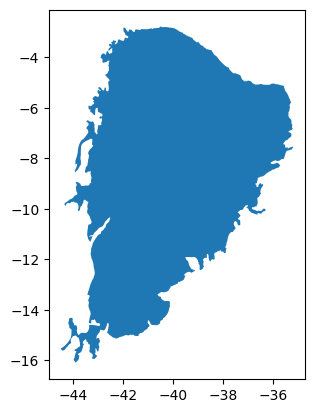

In [538]:
arquivo_shp.plot()

## Criação da máscara para aplicar na variável de interesse

In [539]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.html

# Domínio espacial do arquivo shapefile.
dominio_shapefile = regionmask.Regions(
    outlines=arquivo_shp.geometry.values,
    numbers=[0],
    names={0:'Bioma Caatinga'},
    abbrevs={0:'Caatinga'},
    name='Bioma_Caatinga', 
)

dominio_shapefile

<regionmask.Regions 'Bioma_Caatinga'>
overlap:  False

Regions:
0 Caatinga Bioma Caatinga

[1 regions]

In [540]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.mask.html#regionmask.Regions.mask

# Cria a máscara que será aplicada na variável de interesse.
mascara = dominio_shapefile.mask(
    lon_or_obj=lon,
    lat=lat,
    lon_name='longitude',
    lat_name='latitutde',
)

/home/gui/anaconda3/envs/cbagro/lib/python3.9/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


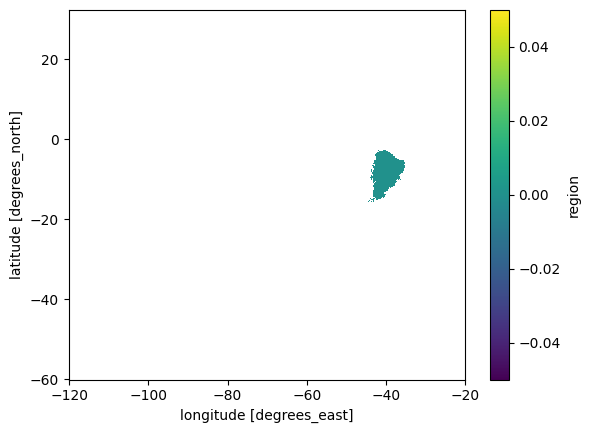

In [541]:
# Plot básico da máscara. NÃO É A VARIÁVEL A SER UTILIZADA!
mascara.plot()

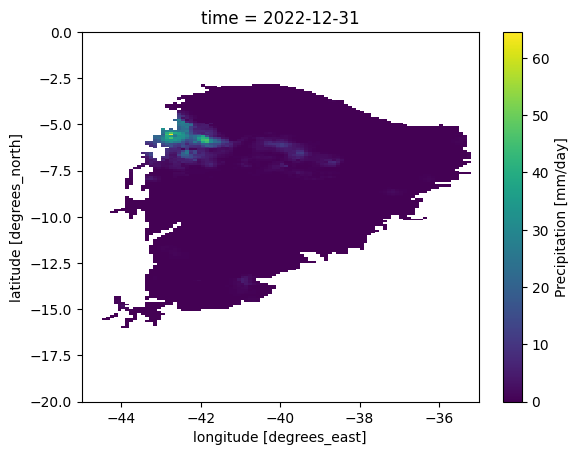

In [542]:
# Aplica a máscara na variável de interesse.
dado_mascarado = prec.where(mascara == mascara)

# Plot básico da variável mascarada. Objetivo deste plot: apenas visualizar
# a variável mascarada para ser se tudo está correto.
# Para a geração de um gráfico mais elaborado, utilizar a biblioteca Matplotlib.
dado_mascarado[-1,:,:].sel(latitude=slice(-20,0),longitude=slice(-45,-35)).plot()

## Cálculo da média espacial

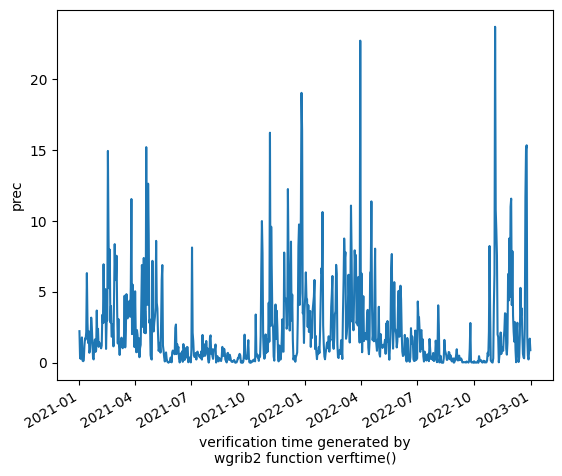

In [543]:
# Os nomes 'latitude' e 'longitude fazem parte do seu arquivo.
media_area = dado_mascarado.mean(dim=('latitude', 'longitude'))

media_area.plot()

# Criação do DataFrame para armazenar a variável

In [544]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

df1 = pd.DataFrame(data=media_area, index=prec.time, columns=['Chuva'])

df1.index.name = 'Dia'

In [545]:
df1

,Chuva
Dia,
2021-01-01,2.229907
2021-01-02,0.344594
2021-01-03,0.275470
2021-01-04,0.852558
2021-01-05,1.790875
...,...
2022-12-27,0.498587
2022-12-28,0.235705
2022-12-29,0.802380


In [546]:
df1.describe()

,Chuva
count,730.000000
mean,2.204857
std,2.954894
min,0.000018
25%,0.344732
50%,1.119899
75%,2.841156
max,23.700052


<AxesSubplot:xlabel='Dia'>

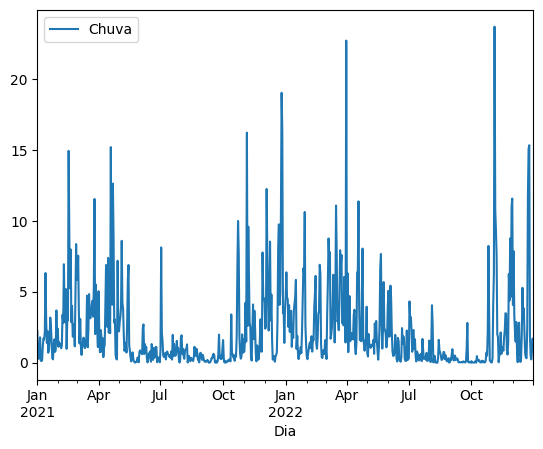

In [547]:
df1.plot()

# Algumas transformações na variável

## Acumulado semanal de precipitação

In [548]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

# A semana começa no domingo.
# 2022-01-02 = domingo -> soma todos os dias até completar domingo.
# 2022-01-09 = domingo -> soma todos os dias entre 03 e 09 (7 dias).

acumulado_semanal = df1.resample('W').sum()

acumulado_semanal

,Chuva
Dia,
2021-01-03,2.849971
2021-01-10,5.959667
2021-01-17,17.360357
2021-01-24,10.233824
2021-01-31,12.006542
...,...
2022-12-04,44.679722
2022-12-11,11.256120
2022-12-18,16.825657


## Acumulado mensal

In [549]:
acumulado_mensal = df1.resample('MS').sum()

acumulado_mensal

,Chuva
Dia,
2021-01-01,48.410362
2021-02-01,109.955765
2021-03-01,97.984390
2021-04-01,112.947556
2021-05-01,56.212402
2021-06-01,22.023800
2021-07-01,31.055187
2021-08-01,17.255524
2021-09-01,9.393928


## Acumulado sazonal

In [550]:
acumulado_sazonal = df1.resample('QS-DEC').sum()

## Acumulado anual

In [551]:
acumulado_anual = df1.resample('YS').sum()

acumulado_anual

,Chuva
Dia,
2021-01-01,787.699158
2022-01-01,821.846619


## Média móvel

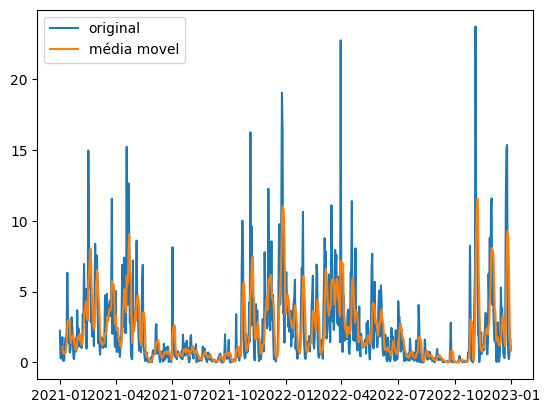

In [552]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

# Média móvel com janela deslizante.
media_movel1 = df1.rolling(window=5).mean()

import matplotlib.pyplot as plt 

plt.plot(df1, label='original')
plt.plot(media_movel1, label='média movel')
plt.legend()

In [553]:
# Média móvel com resample. Janela temporal fixa.
media_movel2 = df1.resample('5D').mean()

media_movel2

,Chuva
Dia,
2021-01-01,1.098681
2021-01-06,0.663247
2021-01-11,2.884527
2021-01-16,1.732698
2021-01-21,1.162401
...,...
2022-12-07,1.379916
2022-12-12,2.201543
2022-12-17,1.427483


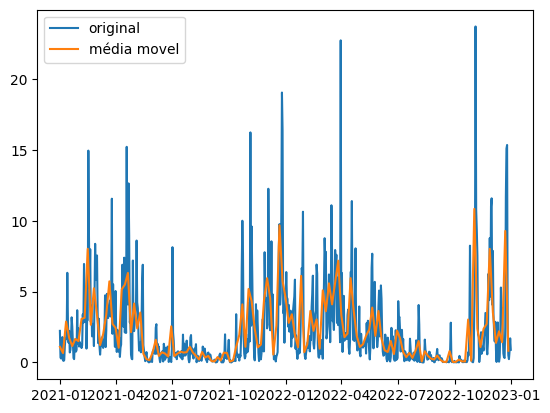

In [554]:
import matplotlib.pyplot as plt 

plt.plot(df1, label='original')
plt.plot(media_movel2, label='média movel')
plt.legend()

## Soma cumulativa

<AxesSubplot:xlabel='Dia'>

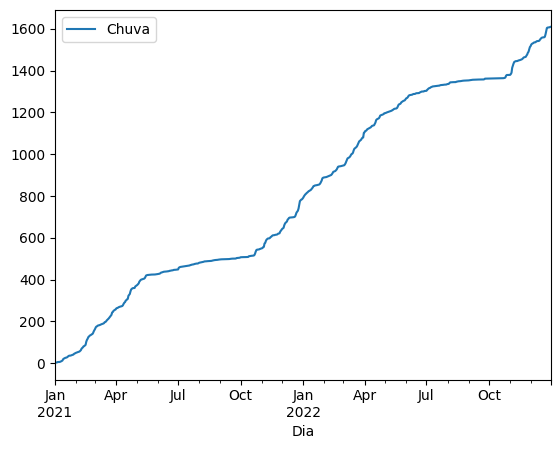

In [555]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html

df1.cumsum().plot()

## Conta a quantidade de valores ausente da variável

In [556]:
df1.isnull().sum()

Chuva    0
dtype: int64

## Compartimentalização (binning)

In [589]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.cut.html

bins1 = [0, 2.5, 7.6, 15, 30, 50, 75, 100]

chuva1 = pd.cut(df1['Chuva'], bins1, right=False)

chuva1.describe

<bound method NDFrame.describe of Dia
2021-01-01    [0.0, 2.5)
2021-01-02    [0.0, 2.5)
2021-01-03    [0.0, 2.5)
2021-01-04    [0.0, 2.5)
2021-01-05    [0.0, 2.5)
                 ...    
2022-12-27    [0.0, 2.5)
2022-12-28    [0.0, 2.5)
2022-12-29    [0.0, 2.5)
2022-12-30    [0.0, 2.5)
2022-12-31    [0.0, 2.5)
Name: Chuva, Length: 730, dtype: category
Categories (7, interval[float64, left]): [[0.0, 2.5) < [2.5, 7.6) < [7.6, 15.0) < [15.0, 30.0) < [30.0, 50.0) < [50.0, 75.0) < [75.0, 100.0)]>

In [590]:
pd.value_counts(chuva1)

Chuva
[0.0, 2.5)       523
[2.5, 7.6)       164
[7.6, 15.0)       35
[15.0, 30.0)       8
[30.0, 50.0)       0
[50.0, 75.0)       0
[75.0, 100.0)      0
Name: count, dtype: int64

<AxesSubplot:xlabel='Chuva'>

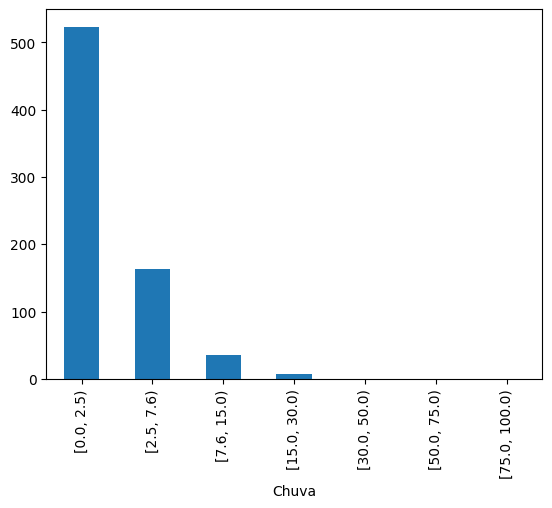

In [591]:
pd.value_counts(chuva1).plot.bar()

In [592]:
df1['bin'] = chuva1

df1

,Chuva,bin
Dia,,
2021-01-01,2.229907,"[0.0, 2.5)"
2021-01-02,0.344594,"[0.0, 2.5)"
2021-01-03,0.275470,"[0.0, 2.5)"
2021-01-04,0.852558,"[0.0, 2.5)"
2021-01-05,1.790875,"[0.0, 2.5)"
...,...,...
2022-12-27,0.498587,"[0.0, 2.5)"
2022-12-28,0.235705,"[0.0, 2.5)"
2022-12-29,0.802380,"[0.0, 2.5)"


In [582]:
# Observação: A quantidade de rótulos (nome2) tem que ser uma quantidade menor que a quantidade de classes (bins2).
nome2 = ['Muito Fraca', 'Fraca', 'Moderada', 'Moderadamente Forte', 'Forte', 'Muito Forte', 'Extremamente Forte']
bins2 = [0, 2.5, 7.6, 15, 30, 50, 75, 100]

chuva2 = pd.cut(df1['Chuva'], bins2, labels=nome2)

chuva2.describe

<bound method NDFrame.describe of Dia
2021-01-01    Muito Fraca
2021-01-02    Muito Fraca
2021-01-03    Muito Fraca
2021-01-04    Muito Fraca
2021-01-05    Muito Fraca
                 ...     
2022-12-27    Muito Fraca
2022-12-28    Muito Fraca
2022-12-29    Muito Fraca
2022-12-30    Muito Fraca
2022-12-31    Muito Fraca
Name: Chuva, Length: 730, dtype: category
Categories (7, object): ['Muito Fraca' < 'Fraca' < 'Moderada' < 'Moderadamente Forte' < 'Forte' < 'Muito Forte' < 'Extremamente Forte']>

In [586]:
pd.value_counts(chuva2)

Chuva
Muito Fraca            523
Fraca                  164
Moderada                35
Moderadamente Forte      8
Forte                    0
Muito Forte              0
Extremamente Forte       0
Name: count, dtype: int64

<AxesSubplot:xlabel='Chuva'>

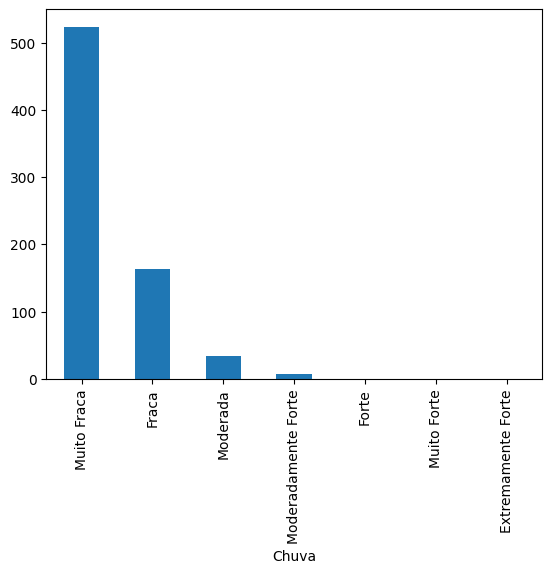

In [595]:
pd.value_counts(chuva2).plot.bar()

In [596]:
df1['Classificacao'] = chuva2

df1

,Chuva,bin,Classificacao
Dia,,,
2021-01-01,2.229907,Muito Fraca,Muito Fraca
2021-01-02,0.344594,Muito Fraca,Muito Fraca
2021-01-03,0.275470,Muito Fraca,Muito Fraca
2021-01-04,0.852558,Muito Fraca,Muito Fraca
2021-01-05,1.790875,Muito Fraca,Muito Fraca
...,...,...,...
2022-12-27,0.498587,Muito Fraca,Muito Fraca
2022-12-28,0.235705,Muito Fraca,Muito Fraca
2022-12-29,0.802380,Muito Fraca,Muito Fraca


## GroupBy

In [562]:
# Acumulado mensal.
chuva_acumulada = df1.resample('MS').sum()

# Cria uma cópia do DataFrame.
df2 = chuva_acumulada.copy()

# Renomeia o index para Mes.
df2.index.name = 'Mes'

df2.describe()

,Chuva
count,24.000000
mean,67.064415
std,45.575436
min,8.672297
25%,28.797340
50%,56.768351
75%,98.613058
max,156.865356


In [563]:
# Cálcula a média mensal.
df2['Media'] = df2.groupby(df2.index.month)['Chuva'].transform('mean')

df2

,Chuva,Media
Mes,,
2021-01-01,48.410362,74.454712
2021-02-01,109.955765,83.640030
2021-03-01,97.984390,127.424873
2021-04-01,112.947556,103.057335
2021-05-01,56.212402,60.915844
2021-06-01,22.023800,31.698555
2021-07-01,31.055187,31.471878
2021-08-01,17.255524,17.737490
2021-09-01,9.393928,9.033113


In [564]:
# Calcula a anomalia.
df2['anomalia'] = df2['Chuva'] - df2['Media']

# Remove o dia da série temporal.
df3 = df2.resample('M', kind='period').mean()

df3

,Chuva,Media,anomalia
Mes,,,
2021-01,48.410362,74.454712,-26.044350
2021-02,109.955765,83.640030,26.315735
2021-03,97.984390,127.424873,-29.440483
2021-04,112.947556,103.057335,9.890221
2021-05,56.212402,60.915844,-4.703442
2021-06,22.023800,31.698555,-9.674755
2021-07,31.055187,31.471878,-0.416691
2021-08,17.255524,17.737490,-0.481966
2021-09,9.393928,9.033113,0.360815


<AxesSubplot:xlabel='Mes'>

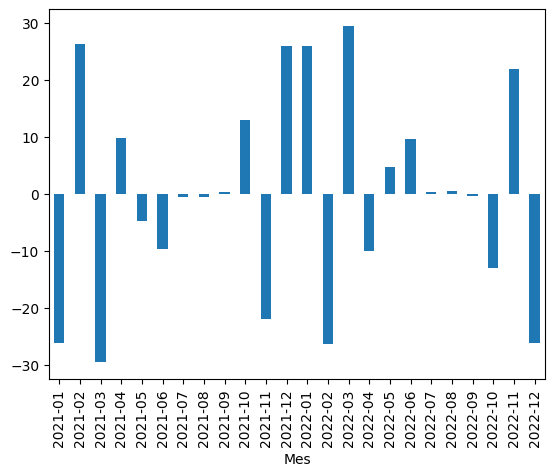

In [565]:
# Plot básico da anomalia.
df3.anomalia.plot.bar()

## Meses mais e menos chuvosos

In [566]:
chuva_acumulada

,Chuva
Dia,
2021-01-01,48.410362
2021-02-01,109.955765
2021-03-01,97.984390
2021-04-01,112.947556
2021-05-01,56.212402
2021-06-01,22.023800
2021-07-01,31.055187
2021-08-01,17.255524
2021-09-01,9.393928


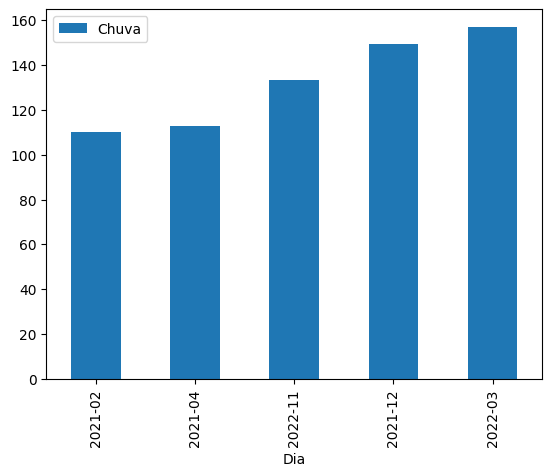

In [567]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html

# Remove o dia da série temporal.
df4 = chuva_acumulada.resample('M', kind='period').mean()

# Os 5 meses mais chuvosos.
meses_mais_chuvoso = df4.nlargest(5, 'Chuva')

# Ordena de forma crescente os valores dos meses mais chuvosos.
meses_ordem_crescente = meses_mais_chuvoso.sort_values(by='Chuva').plot.bar()

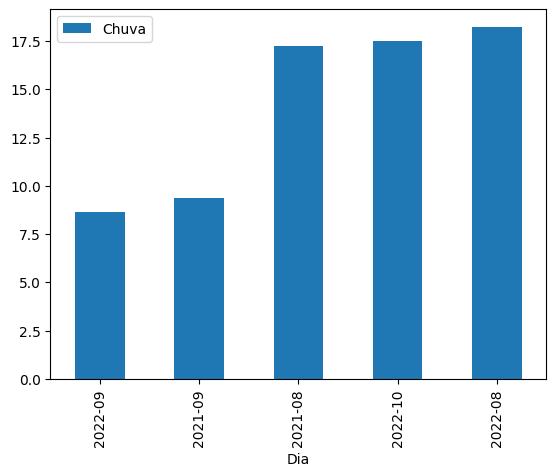

In [568]:
# Documentação
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nsmallest.html

# Os 5 meses menos chuvosos.
meses_menos_chuvoso = df4.nsmallest(5, 'Chuva')

# Ordena de forma crescente os valores dos meses mais chuvosos.
meses_ordem_crescente = meses_menos_chuvoso.sort_values(by='Chuva').plot.bar()